In [1]:
!pip install langdetect

from google.colab import files

uploaded = files.upload()

     |████████████████████████████████| 981 kB 14.9 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=fbd3b6981e8bd404cb189a7be6e0cebc4a15654786e0510826ce3bda75a2444f
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


Saving songs_w_lyrics.json to songs_w_lyrics.json


In [3]:
import json, langdetect
import pandas as pd

with open('songs_w_lyrics.json', 'r') as f: 
    songs = json.load(f)

song_lens = {}
max_len = -1
y = []
X = []

for g in songs:
    for t in songs[g]:
        lang = langdetect.detect(t[2].strip()) 
        if (lang != 'en'):
            songs[g].remove(t)
            continue

for g in songs:
    if len(songs[g]) > max_len:
        max_len = len(songs[g])
    song_lens[g] = len(songs[g])
    
for g in songs:
    c = 0
    while (len(songs[g]) != max_len):
        if (c == song_lens[g]):
            c = 0
        songs[g].append(songs[g][c])
        c += 1

data = {'artist': [], 'song': [], 'lyrics': [], 'genre': []}

for g in songs:
    for (s, a, l) in songs[g]:
        data['artist'].append(a)
        data['song'].append(s)
        
        data['lyrics'].append(l)
        data['genre'].append(g)

df = pd.DataFrame.from_dict(data)

df.describe()
df.head()

df.columns

df['genre'].value_counts()

R&B                   1055
Country               1055
Pop                   1055
Dance/Electronic      1055
Metal                 1055
Christian & Gospel    1055
Folk & Acoustic       1055
Hip-Hop               1055
Rock                  1055
Name: genre, dtype: int64

In [4]:
import re, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text.replace('\n', ' ')
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df['lyrics'] = df['lyrics'].apply(clean_text)
#df['lyrics'] = df['lyrics'].str.replace('\d+', ' ')

In [ ]:
df.head()

,artist,song,lyrics,genre
0,Sueco,Paralyzed,got big ego could see telescope way always arg...,Rock
1,Papa Roach,Kill The Noise,feel like channeling something kill noise love...,Rock
2,Mammoth WVH,Don’t Back Down,breathe madness around feelin like end days th...,Rock
3,Foals,Wake Me Up,wake wake walking dream walking finest place e...,Rock
4,Stand Atlantic,"deathwish (feat. nothing,nowhere.)",make head spin god knows win know think got fu...,Rock


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [7]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['lyrics'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 38090 unique tokens.


In [8]:
X = tokenizer.texts_to_sequences(df['lyrics'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9495, 250)


In [9]:
Y = pd.get_dummies(df['genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (9495, 9)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8545, 250) (8545, 9)
(950, 250) (950, 9)


In [11]:
from keras import Sequential
from keras.layers import Dense, SpatialDropout1D, LSTM, Embedding


In [16]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

In [17]:
from keras.callbacks import EarlyStopping

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
121/121 [==============================] - 66s 521ms/step - loss: 2.0619 - accuracy: 0.2081 - val_loss: 1.9210 - val_accuracy: 0.2772
Epoch 2/5
121/121 [==============================] - 63s 519ms/step - loss: 1.8264 - accuracy: 0.3350 - val_loss: 1.8555 - val_accuracy: 0.3181
Epoch 3/5
121/121 [==============================] - 63s 521ms/step - loss: 1.5425 - accuracy: 0.4651 - val_loss: 1.7549 - val_accuracy: 0.3965
Epoch 4/5
121/121 [==============================] - 63s 521ms/step - loss: 1.2117 - accuracy: 0.6009 - val_loss: 1.5072 - val_accuracy: 0.4994
Epoch 5/5
121/121 [==============================] - 63s 521ms/step - loss: 0.8898 - accuracy: 0.7203 - val_loss: 1.5131 - val_accuracy: 0.5392


In [18]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

30/30 [==============================] - 1s 48ms/step - loss: 1.5029 - accuracy: 0.5368
Test set
  Loss: 1.503
  Accuracy: 0.537


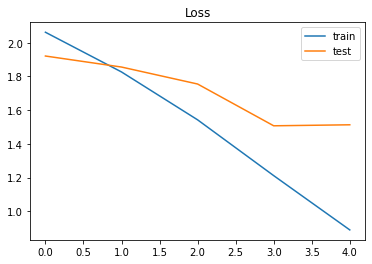

In [20]:
from matplotlib import pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

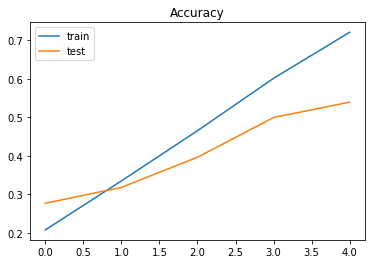

In [22]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();